<a href="https://colab.research.google.com/github/ggsmith842/pytorch-tutorials/blob/main/Unidirectional_SL_RNN_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install datasets -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda

In [3]:
import os
import time
import nltk
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt


from tqdm import tqdm
from string import punctuation
from collections import Counter
from nltk.corpus import stopwords
from datasets import load_dataset, concatenate_datasets
from torch.utils.data import DataLoader, TensorDataset

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
# load imdb dataset from huggingface
ds = load_dataset("stanfordnlp/imdb")

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:
merged_dataset = concatenate_datasets([ds['train'], ds['test']])
split_dataset = merged_dataset.train_test_split(test_size=0.25, shuffle=True, seed=42)

train = split_dataset['train']
test = split_dataset['test']

In [8]:
# pre-process text reviews
def build_vocab(text):
  # apply lowercase to all text
  stop_words = set(stopwords.words('english'))
  lowercase_text = [review.lower() for review in text]
  # remove punctuation
  nopunc_text = [''.join([letter for letter in review if letter not in punctuation]) for review in lowercase_text]
  cleaned_text = [' '.join(word for word in review.split() if word not in stop_words) for review in nopunc_text]
  reviews_blob =' '.join(cleaned_text)

  word_count = Counter(reviews_blob.split()).most_common()
  print(f'Top 10 words:\n{word_count[:10]}')

  # create word to integer token dictionary
  # to encode text as numbers
  vocab = {word:idx+1 for idx, (word, count) in enumerate(word_count)}

  return (cleaned_text, vocab)


In [9]:
def tokenize(cleaned_text, vocab):
  review_tokens = []
  for review in cleaned_text:
    word_tokens = [vocab[word] for word in review.split()]
    review_tokens.append(word_tokens)
  return review_tokens

In [10]:
# pad sequence
def pad_sequence(review_tokens, seq_len):
  padded_reviews = np.zeros((len(review_tokens), seq_len), dtype=int)

  for idx, review in enumerate(review_tokens):
    review_len = len(review)
    if review_len <= seq_len:
      zeros = list(np.zeros(
          seq_len - review_len
      ))
      new_seq = zeros + review
    elif review_len > seq_len:
      new_seq = review[0:seq_len]

    padded_reviews[idx,:] = np.array(new_seq)
  return padded_reviews

In [11]:
train_clean_text, train_vocab = build_vocab(train['text'])
train_tokens = tokenize(train_clean_text, train_vocab)

Top 10 words:
[('br', 85431), ('movie', 62475), ('film', 55885), ('one', 38167), ('like', 29155), ('good', 21418), ('even', 18351), ('would', 17996), ('time', 17440), ('really', 17239)]


In [12]:
print(train_clean_text[0])
print(train_tokens[0])

movie one boring horror movies seen long time seen lot personally liked piercing take original pretty unwatchable could stand dee snider actor singer seemed trying everything said make memorable quote werent get movies free still didnt think worth time get
[2, 4, 239, 98, 25, 32, 102, 9, 32, 75, 1146, 304, 11154, 94, 112, 86, 4002, 26, 758, 4751, 13817, 191, 1817, 337, 154, 158, 198, 24, 749, 3092, 1020, 15, 25, 836, 46, 60, 29, 166, 9, 15]


(array([2.8032e+04, 7.1410e+03, 1.7150e+03, 5.7900e+02, 2.3000e+01,
        4.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([   4. ,  148.5,  293. ,  437.5,  582. ,  726.5,  871. , 1015.5,
        1160. , 1304.5, 1449. ]),
 <BarContainer object of 10 artists>)

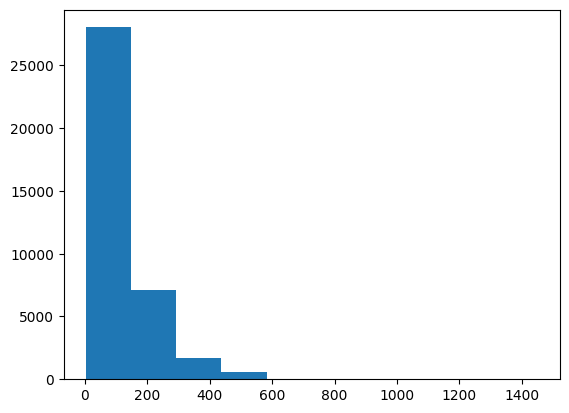

In [13]:
padded_reviews = pad_sequence(train_tokens, seq_len=512)
plt.hist([len(review) for review in train_tokens])

Top 10 words:
[('br', 28363), ('movie', 21035), ('film', 18568), ('one', 12857), ('like', 9834), ('good', 7151), ('even', 6221), ('would', 6028), ('time', 5817), ('really', 5709)]


(array([8.133e+03, 2.997e+03, 8.960e+02, 3.270e+02, 1.350e+02, 8.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([   3. ,  118.2,  233.4,  348.6,  463.8,  579. ,  694.2,  809.4,
         924.6, 1039.8, 1155. ]),
 <BarContainer object of 10 artists>)

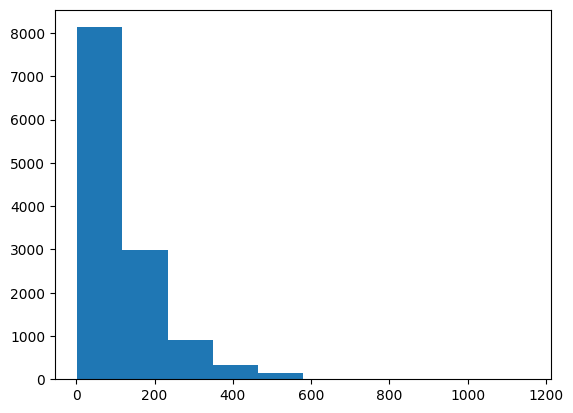

In [14]:
# preprocess test set
test_clean_text, test_vocab = build_vocab(test['text'])
test_tokens = tokenize(test_clean_text, test_vocab)
test_padded_reviews = pad_sequence(test_tokens, seq_len=512)
plt.hist([len(review) for review in test_tokens])

## Train & Validation Loader

In [15]:
# create custom datasets
train_dataset = TensorDataset(
    torch.from_numpy(padded_reviews).to(device),
    torch.from_numpy(np.array(train['label'])).float().to(device)
)

test_dataset = TensorDataset(
      torch.from_numpy(test_padded_reviews).to(device),
    torch.from_numpy(np.array(test['label'])).float().to(device)
)


In [16]:
# create dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size = 32,
    shuffle = True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle = True
)

In [17]:
train_data_features, train_labels = next(iter(train_dataloader))
print(f'Example Input Size: {train_data_features.size()}')
print(f'Example Input:\n {train_data_features}\n')

print(f'Example Output Size: {train_labels.size()}')
print(f'Example Output:\n {train_labels}')

Example Input Size: torch.Size([32, 512])
Example Input:
 tensor([[     0,      0,      0,  ...,   8110, 106963,   1769],
        [     0,      0,      0,  ...,   1037,   1900,  61312],
        [     0,      0,      0,  ...,    656,     38,   1300],
        ...,
        [     0,      0,      0,  ...,    160,     38,     13],
        [     0,      0,      0,  ...,    336,      9,     57],
        [     0,      0,      0,  ...,   6080,    385,   4293]],
       device='cuda:0')

Example Output Size: torch.Size([32])
Example Output:
 tensor([1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
       device='cuda:0')


# Model Instantiation and Training

In [53]:
class RNN(nn.Module):
  def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
    super().__init__()

    self.embedding_layer = nn.Embedding(input_dim, embedding_dim)
    self.rnn_layer = nn.RNN(embedding_dim, hidden_dim, num_layers=1)
    self.fc_layer = nn.Linear(hidden_dim, output_dim)

  def forward(self, sequence):

    # seq shape = seq_len, batch_size
    embedding = self.embedding_layer(sequence)
    output, hidden_state = self.rnn_layer(embedding)

    final_output =self.fc_layer(
        hidden_state[-1,:,:].squeeze(0)
    )

    return final_output


In [54]:
input_dim = len(train_vocab) + 1
embedding_dim = 100
hidden_dim = 32
output_dim = 1

In [55]:
rnn_model = RNN(input_dim, embedding_dim, hidden_dim, output_dim)
optimizer = optim.Adam(rnn_model.parameters())
loss_func = nn.BCEWithLogitsLoss()
rnn_model = rnn_model.to(device)
loss_func = loss_func.to(device)

In [56]:
def accuracy_metric(predictions, labels):
  """Returns 0-1 accuracy for the given set of predictions and labels"""
  rounded_predictions = torch.round(torch.sigmoid(predictions))
  success = (rounded_predictions == labels).float()
  return success.sum() / len(success)

In [98]:
def training_loop(model, dataloader, optim, loss_func):
  loss = 0
  accuracy = 0
  model.train()

  for seq, sentiment in dataloader:
    optim.zero_grad()
    predictions = model(seq.T).squeeze()
    loss_curr = loss_func(predictions,sentiment)
    accuracy_curr = accuracy_metric(predictions, sentiment)
    loss_curr.backward()
    optim.step()
    loss += loss_curr.item()
    accuracy += accuracy_curr.item()
  return loss/len(dataloader), accuracy/len(dataloader)

def validate(model, dataloader, loss_func):
  loss = 0
  accuracy = 0
  model.eval()
  with torch.no_grad():
    for seq, sentiment in dataloader:
      predictions = model(seq.T).squeeze()
      loss_curr = loss_func(predictions,sentiment)
      accuracy_curr = accuracy_metric(predictions, sentiment)
      loss += loss_curr.item()
      accuracy += accuracy_curr.item()
  return loss/len(dataloader), accuracy/len(dataloader)

In [58]:
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
  time_start = time.time()
  training_loss, training_accuracy = training_loop(
      rnn_model, train_dataloader, optimizer, loss_func)
  validation_loss, validation_accuracy = validate(
      rnn_model, test_dataloader, loss_func)

  time_end = time.time()
  time_delta = time_end - time_start

  if validation_loss < best_val_loss:
    best_val_loss = validation_loss
    torch.save(rnn_model.state_dict(), 'rnn_model.pt')

  print(f'epoch: {epoch+1} | time elapsed: {time_delta}s')
  print(f'training loss: {training_loss:.3f} | training accuracy: {training_accuracy*100:.2f}%')
  print(f'validation loss: {validation_loss:.3f} | validation accuracy: {validation_accuracy*100:.2f}%')

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.DoubleTensor instead (while checking arguments for embedding)

Test how the model performs using embeddings with no manual preprocessing

In [ ]:
%pip install mistralai -qq

In [ ]:
from time import sleep
from mistralai import Mistral
from google.colab import userdata
api_key = userdata.get('MISTRAL_API_KEY')

In [ ]:
def get_embeddings_by_chunk(data, chunk_size):
  client = Mistral(api_key)
  chunks = [data[x: x + chunk_size] for x in range(0, len(data), chunk_size)]
  embeddings_resp = []
  for c in chunks:
    embeddings_resp.append(client.embeddings.create(model='mistral-embed', inputs = c))
    sleep(2)
  return [d.embedding for e in embeddings_resp for d in e.data]

In [ ]:
train_embeddings = get_embeddings_by_chunk(train['text'][:1000], 100)

In [ ]:
test_embeddings = get_embeddings_by_chunk(test['text'][:300], 150)

In [66]:
train_dataset = TensorDataset(
    torch.from_numpy(np.array(train_embeddings)).type(torch.float32).to(device), # Convert to float32
    torch.from_numpy(np.array(train['label'][:1000])).float().to(device)
)

test_dataset = TensorDataset(
      torch.from_numpy(np.array(test_embeddings)).type(torch.float32).to(device), # Convert to float32
    torch.from_numpy(np.array(test['label'][:300])).float().to(device)
)


In [67]:
# create dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size = 32,
    shuffle = True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle = True
)

In [83]:
train_data_features, train_labels = next(iter(train_dataloader))
print(f'Example Input Size: {train_data_features.size()}')
print(f'Example Input:\n {train_data_features}\n')

print(f'Example Output Size: {train_labels.size()}')
print(f'Example Output:\n {train_labels}')

Example Input Size: torch.Size([32, 1024])
Example Input:
 tensor([[-0.0436,  0.0382,  0.0322,  ..., -0.0156,  0.0080,  0.0161],
        [-0.0502,  0.0218,  0.0522,  ...,  0.0108, -0.0085, -0.0271],
        [-0.0410,  0.0332,  0.0256,  ..., -0.0065, -0.0100, -0.0340],
        ...,
        [-0.0235,  0.0356,  0.0196,  ..., -0.0072,  0.0032, -0.0171],
        [-0.0269,  0.0002,  0.0151,  ..., -0.0036,  0.0047, -0.0126],
        [-0.0296,  0.0150,  0.0336,  ..., -0.0064,  0.0253, -0.0243]],
       device='cuda:0')

Example Output Size: torch.Size([32])
Example Output:
 tensor([0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
        1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0.],
       device='cuda:0')


In [ ]:
def training_loop(model, dataloader, optim, loss_func):
  loss = 0
  accuracy = 0
  model.train()

  for seq, sentiment in dataloader:
    optim.zero_grad()
    predictions = model(seq).squeeze()
    loss_curr = loss_func(predictions,sentiment)
    accuracy_curr = accuracy_metric(predictions, sentiment)
    loss_curr.backward()
    optim.step()
    loss += loss_curr.item()
    accuracy += accuracy_curr.item()
  return loss/len(dataloader), accuracy/len(dataloader)

def validate(model, dataloader, loss_func):
  loss = 0
  accuracy = 0
  model.eval()
  with torch.no_grad():
    for seq, sentiment in dataloader:
      predictions = model(seq).squeeze()
      loss_curr = loss_func(predictions,sentiment)
      accuracy_curr = accuracy_metric(predictions, sentiment)
      loss += loss_curr.item()
      accuracy += accuracy_curr.item()
  return loss/len(dataloader), accuracy/len(dataloader)

In [94]:
class FFNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):  # x: [batch_size, input_dim]
        x = self.relu(self.fc1(x))
        return self.fc2(x)


In [95]:
input_dim = len(train_embeddings[0])
embedding_dim = 32
hidden_dim = 32
output_dim = 1

In [96]:
model = FFNClassifier(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters())
loss_func = nn.BCEWithLogitsLoss()
model = model.to(device)
loss_func = loss_func.to(device)

In [99]:
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
  time_start = time.time()
  training_loss, training_accuracy = training_loop(
      model, train_dataloader, optimizer, loss_func)
  validation_loss, validation_accuracy = validate(
      model, test_dataloader, loss_func)

  time_end = time.time()
  time_delta = time_end - time_start

  if validation_loss < best_val_loss:
    best_val_loss = validation_loss
    torch.save(model.state_dict(), 'model.pt')

  print(f'epoch: {epoch+1} | time elapsed: {time_delta}s')
  print(f'training loss: {training_loss:.3f} | training accuracy: {training_accuracy*100:.2f}%')
  print(f'validation loss: {validation_loss:.3f} | validation accuracy: {validation_accuracy*100:.2f}%')

epoch: 1 | time elapsed: 0.15879011154174805s
training loss: 0.681 | training accuracy: 54.20%
validation loss: 0.663 | validation accuracy: 73.75%
epoch: 2 | time elapsed: 0.06207776069641113s
training loss: 0.639 | training accuracy: 86.52%
validation loss: 0.615 | validation accuracy: 76.35%
epoch: 3 | time elapsed: 0.06292080879211426s
training loss: 0.577 | training accuracy: 88.18%
validation loss: 0.550 | validation accuracy: 87.71%
epoch: 4 | time elapsed: 0.06148886680603027s
training loss: 0.500 | training accuracy: 91.70%
validation loss: 0.473 | validation accuracy: 91.67%
epoch: 5 | time elapsed: 0.06619477272033691s
training loss: 0.423 | training accuracy: 93.26%
validation loss: 0.408 | validation accuracy: 92.50%
epoch: 6 | time elapsed: 0.06203627586364746s
training loss: 0.355 | training accuracy: 93.07%
validation loss: 0.345 | validation accuracy: 92.81%
epoch: 7 | time elapsed: 0.06268501281738281s
training loss: 0.304 | training accuracy: 94.92%
validation loss: 